In [1]:
import pyspark, pickle
from pyspark import SparkContext
from pyspark.sql.functions import countDistinct
from pyspark.storagelevel import StorageLevel
import pandas as pd
import numpy as np

from pyspark.ml.feature import CountVectorizer, StringIndexer, StopWordsRemover, NGram, RegexTokenizer

from nltk.corpus import stopwords
import nltk, re

from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline

from pyspark.sql.types import StringType

# from sklearn import svm, grid_search, datasets
# from spark_sklearn import GridSearchCV
from sklearn.model_selection import GridSearchCV
pd.options.display.max_colwidth = -1

<ipython-input-1-3ef3e947392d>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.options.display.max_colwidth = -1


In [2]:
# d_df = pickle.load( open('d_df.pkl', "rb" ) )
# b_df = pickle.load( open('b_df.pkl', "rb" ) )
a_df = pickle.load( open('a_df.pkl', "rb" ) )
# d_tweets = pickle.load( open('d_tweets.pkl', "rb" ) )
for i, tweet in enumerate(a_df['tweet']):
    a_df['tweet'].iloc[i] = tweet.rsplit(' ', 1)[0]

/Users/SirLawrenceKatz/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
# from sklearn.feature_extraction.text import CountVectorizer

# cv1 = CountVectorizer(stop_words='english')

# X_cv1 = cv1.fit_transform(d_tweets)

# pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names()).head()

In [10]:
# d_tweets.shape

(6777,)

In [3]:
# #removing bots by eliminating duplicates
# nd_tweets = list(set(d_tweets))
# len(nd_tweets)

6475

In [3]:
a_df

,created_at,date,time,timezone,user_id,username,name,tweet,language,mentions,urls,retweets_count,hashtags,cashtags,link,reply_to,translate
1,2017-12-28 15:59:59 PST,2017-12-28,15:59:59,-800,41223126,stonekettle,Stonekettle,wigwam he could have stopped being an asshole at any time i stopped feeling any sympathy for him whatsoever the minute he told me to buy a gun and kill myself what if it wasn t me what if it was a kid he was attacking motherfucker got what he deserved,en,[],[],3,[],[],https://twitter.com/Stonekettle/status/946531203015958528,"[{'screen_name': 'wigwam', 'name': 'Wigwam Jones', 'id': '5561562'}]",NaN
2,2017-12-28 15:59:58 PST,2017-12-28,15:59:58,-800,20731354,fixedintime,Larry Cahoon,billmaher nope they just might pull out a gun,en,[],[],0,[],[],https://twitter.com/fixedintime/status/946531199245258753,"[{'screen_name': 'billmaher', 'name': 'Bill Maher', 'id': '19697415'}]",NaN
3,2017-12-28 15:59:56 PST,2017-12-28,15:59:56,-800,829051374491033602,rdtpokescans,RDT Scans,lapras ♀ water gun blizzard iv cp l until https t co,en,[],"['http://maps.google.com/maps?q=35.84465724427497,-78.6280375087247']",0,[],[],https://twitter.com/rdtpokescans/status/946531190588297216,[],NaN
4,2017-12-28 15:59:52 PST,2017-12-28,15:59:52,-800,852324146801287168,milhouzze_,Tessa,clingciang he’s making gun and bomb noises he might be having,en,[],[],0,[],[],https://twitter.com/milhouzze_/status/946531174318448640,[],NaN
5,2017-12-28 15:59:49 PST,2017-12-28,15:59:49,-800,833078171461414912,campokescans,CAM Scans,lapras ♀ water gun hydro pump iv cp l until https t co,en,[],"['http://maps.google.com/maps?q=35.80637453661017,-78.79317428814133']",0,[],[],https://twitter.com/campokescans/status/946531162897469440,[],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106073,2017-12-26 05:55:23 PST,2017-12-26,05:55:23,-800,927938968972341248,sunshinsepam2su,Sunshine pam,formyblockchi gun buybacks block watch youth programs and job training what s your governor or mayor doi g for you moms,en,[],[],0,[],[],https://twitter.com/Sunshinsepam2su/status/945654275186810883,"[{'screen_name': 'fox32news', 'name': 'FOX 32 News', 'id': '7663702'}]",NaN
106076,2017-12-26 05:55:11 PST,2017-12-26,05:55:11,-800,1251974096,oxer07,Brett oxer,what a goal machine hkane is can’t believe no big guns have come in him,en,"[{'screen_name': 'hkane', 'name': 'harry kane', 'id': '240664869'}]",[],0,[],[],https://twitter.com/Oxer07/status/945654224221765632,[],NaN
106077,2017-12-26 05:55:00 PST,2017-12-26,05:55:00,-800,4655179521,sninskypeter,Peter Sninsky,i added a video to a youtube playlist https t co opening christmas presents nerf rampage elite n strike gun,en,"[{'screen_name': 'youtube', 'name': 'youtube', 'id': '10228272'}]",['http://youtu.be/r17itnTspX8?a'],0,[],[],https://twitter.com/SninskyPeter/status/945654177899757568,[],NaN
106079,2017-12-26 05:54:59 PST,2017-12-26,05:54:59,-800,2329177474,webby1882,Dean Webb,another hattrick for the machine gun stop it boreoff ridiculous,en,[],[],0,"['boreoff', 'ridiculous', 'totsou']",[],https://twitter.com/Webby1882/status/945654173667938304,[],NaN


In [4]:
d_tweets = a_df[['username','tweet', 'date', 'timezone']].copy()


In [5]:
d_tweets.tweet = d_tweets.tweet.str.replace('https?://[^ ,]+', '[link]') #replace links with '[link]'d

In [6]:
d_tweets = d_tweets[d_tweets.tweet != '[link]']

In [7]:
d_tweets.shape
d_tweets.iloc[2]['tweet']

d_tweets

,username,tweet,date,timezone
1,stonekettle,wigwam he could have stopped being an asshole at any time i stopped feeling any sympathy for him whatsoever the minute he told me to buy a gun and kill myself what if it wasn t me what if it was a kid he was attacking motherfucker got what he deserved,2017-12-28,-800
2,fixedintime,billmaher nope they just might pull out a gun,2017-12-28,-800
3,rdtpokescans,lapras ♀ water gun blizzard iv cp l until https t co,2017-12-28,-800
4,milhouzze_,clingciang he’s making gun and bomb noises he might be having,2017-12-28,-800
5,campokescans,lapras ♀ water gun hydro pump iv cp l until https t co,2017-12-28,-800
...,...,...,...,...
106073,sunshinsepam2su,formyblockchi gun buybacks block watch youth programs and job training what s your governor or mayor doi g for you moms,2017-12-26,-800
106076,oxer07,what a goal machine hkane is can’t believe no big guns have come in him,2017-12-26,-800
106077,sninskypeter,i added a video to a youtube playlist https t co opening christmas presents nerf rampage elite n strike gun,2017-12-26,-800
106079,webby1882,another hattrick for the machine gun stop it boreoff ridiculous,2017-12-26,-800


In [9]:

# spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [8]:

# # Create spark dataframe of tweets called 'tweets spark'

# tweet_sp = spark.createDataFrame(d_tweets)
# tweet_sp.persist()
# tweet_sp.show()


In [9]:
# (train, test) = tweet_sp.randomSplit([0.7, 0.3], seed = 100)

# train.persist()
# test.persist()

# print(train.count())
# print(test.count())
# d_tweets.iloc[2]['tweet']

In [12]:

# Create regex tokenizer that is useful for Twitter data (preserves emoticons, hashtags, etc.)
# I used code from here, with some modifications: https://github.com/adonoho/TweetTokenizers/blob/master/PottsTweetTokenizer.py

# I got rid of ellipsis matcher
# I modified words with apostrophes to not keep after the apostrophe
# I got rid of the 'everything else that isn't whitespace' matcher
# I added regex to capture words in quotes as separate items: r'(?:["\'][a-zA-Z0-9/-]+["\'])'
# pattern = r"""(?:\[link\])|(?:(?:\+?[01][\-\s.]*)?(?:[\(]?\d{3}[\-\s.\)]*)?\d{3}[\-\s.]*\d{4})|(?:(?<= )[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?)|(<[^>]+>)|(?:@[\w_]+)|(?:\#+[\w_]+[\w\'_\-]*[\w_]+)|(?:["\'][a-z0-9/-]+["\'])|(?:[a-z][a-z\-_]+[a-z])|(?:[+\-]?\d+[,/.:-]\d+[+\-]?)|(?:[\w_]+)"""

# word_re = re.compile(pattern, re.VERBOSE | re.I | re.UNICODE)


In [10]:
# df = spark.createDataFrame([d_tweets.iloc[2]['tweet'], d_tweets.iloc[5]['tweet']],
#                            StringType())
# df.show()

In [8]:
# RegexTokenizer(inputCol="value", outputCol="tokens", gaps=False, pattern=word_re.pattern).transform(df).take(2)

In [65]:
# # Train model
# nb_model = cv_pipe.fit(train)


In [68]:

# # Count Vectorize my data
# countvec_data_svm = pipeline_svm.fit(train).transform(train)
# countvec_data_svm.show()

In [10]:
# clean = filtration(d_tweets, "content")
dict_d_tweets = d_tweets.to_dict('list')
# dict_d_tweets

In [11]:
dict_d_tweets2 = dict_d_tweets['tweet']
dict_d_tweets2[:5]

[' wigwam he could have stopped being an asshole at any time    i stopped feeling any sympathy for him whatsoever the minute he told me to buy a gun and kill myself    what if it wasn t me  what if it was a kid he was attacking  motherfucker got what he deserved',
 ' billmaher nope  they just might pull out a gun',
 'lapras ♀ water gun blizzard  iv       cp      l    until         https   t co ',
 ' clingciang he’s making gun and bomb noises    he might be having',
 'lapras ♀ water gun hydro pump  iv       cp      l    until         https   t co ']

In [12]:

import spacy
import nltk
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim
from collections import Counter
from gensim.corpora.dictionary import Dictionary
nlp = spacy.load('en_core_web_sm')


In [13]:
tokenized_tweets = []
for tweet in dict_d_tweets2:
    tokenized_tweet = nlp(tweet)
    
    tweet = "" # we want to keep each tweet seperate
    
    for token in tokenized_tweet:
        if token.is_space:
            continue
        elif token.is_punct:
            continue
        elif token.is_stop:
            continue
        elif token.is_digit:
            continue
        elif len(token) == 1:
            continue
        elif len(token) == 2:
            continue
        else:
            tweet += str(token.lemma_) + " " #creating lemmatized version of tweet
        
    tokenized_tweets.append(tweet)
tokenized_tweets = list(map(str.strip, tokenized_tweets)) # strip whitespace
# tokenized_tweets = [x for x in tokenized_tweets if x != ""] # remove empty entries

In [14]:

tokenized_tweets[:5] 

['wigwam stop asshole time stop feel sympathy whatsoever minute tell buy gun kill wasn kid attack motherfucker get deserve',
 'billmaher nope pull gun',
 'lapra water gun blizzard https',
 'clingciang make gun bomb noise have',
 'lapra water gun hydro pump https']

In [15]:
dict_d_tweets['tokenized_tweets'] = tokenized_tweets

dict_d_tweets_df = pd.DataFrame.from_dict(dict_d_tweets, orient='index')

In [16]:
tok_df = dict_d_tweets_df.T
tok_df.notnull().tail(30)
# tok_df.drop([6771, 6772, 6773, 6774, 6775, 6776], inplace=True)
# tok_df.drop([6770], inplace=True)
tok_df


,username,tweet,date,timezone,tokenized_tweets
0,stonekettle,wigwam he could have stopped being an asshole at any time i stopped feeling any sympathy for him whatsoever the minute he told me to buy a gun and kill myself what if it wasn t me what if it was a kid he was attacking motherfucker got what he deserved,2017-12-28,-800,wigwam stop asshole time stop feel sympathy whatsoever minute tell buy gun kill wasn kid attack motherfucker get deserve
1,fixedintime,billmaher nope they just might pull out a gun,2017-12-28,-800,billmaher nope pull gun
2,rdtpokescans,lapras ♀ water gun blizzard iv cp l until https t co,2017-12-28,-800,lapra water gun blizzard https
3,milhouzze_,clingciang he’s making gun and bomb noises he might be having,2017-12-28,-800,clingciang make gun bomb noise have
4,campokescans,lapras ♀ water gun hydro pump iv cp l until https t co,2017-12-28,-800,lapra water gun hydro pump https
...,...,...,...,...,...
78537,sunshinsepam2su,formyblockchi gun buybacks block watch youth programs and job training what s your governor or mayor doi g for you moms,2017-12-26,-800,formyblockchi gun buyback block watch youth program job training governor mayor doi mom
78538,oxer07,what a goal machine hkane is can’t believe no big guns have come in him,2017-12-26,-800,goal machine hkane believe big gun come
78539,sninskypeter,i added a video to a youtube playlist https t co opening christmas presents nerf rampage elite n strike gun,2017-12-26,-800,add video youtube playlist https open christmas present nerf rampage elite strike gun
78540,webby1882,another hattrick for the machine gun stop it boreoff ridiculous,2017-12-26,-800,hattrick machine gun stop boreoff ridiculous


In [17]:
import nltk
# nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words("english")



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/SirLawrenceKatz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/SirLawrenceKatz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
sw = sw + ['gun', 'guns', 'http', 'https', 'guns n roses', 'guns and roses', 'kelly', 'water', 'lapra', 'lapras', 'hydro','blizzard']
vectorizer = CountVectorizer(min_df=10, stop_words = sw)
doc_word = vectorizer.fit_transform(tok_df['tokenized_tweets'].str.replace(r'\d+','',regex=True))
d_tweets['tweet'][5]
doc_word
pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names()).head()

/Users/SirLawrenceKatz/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['roses'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,aaron,abandon,abc,abcnew,abfalecbaldwin,abide,ability,able,aboard,abolish,...,zia,zimbabwe,zip,zombie,zone,zoo,zurich,ออฟก,เบบ,バンドでアルファベット作るとその人の音楽趣味が分かる
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# Create TF-IDF matrix for full corpus from tweets
from sklearn.feature_extraction.text import TfidfVectorizer
fulltfidf = TfidfVectorizer(min_df=10, stop_words = sw)
tfidf_full = fulltfidf.fit_transform(tok_df['tokenized_tweets'].str.replace(r'\d+','',regex=True))
tfidf_full
pd.DataFrame(tfidf_full.toarray(), columns=fulltfidf.get_feature_names()).head()

/Users/SirLawrenceKatz/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['roses'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,aaron,abandon,abc,abcnew,abfalecbaldwin,abide,ability,able,aboard,abolish,...,zia,zimbabwe,zip,zombie,zone,zoo,zurich,ออฟก,เบบ,バンドでアルファベット作るとその人の音楽趣味が分かる
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# def preprocess_textstem(text):
#     # Remove numbers
#     text = re.sub(r'\d+', '', text)
    
#     # Tokenise words while ignoring punctuation
#     tokeniser = RegexpTokenizer(r'\w+')
#     tokens = tokeniser.tokenize(text)
    
#      # Lowercase and stem
#     stemmer = LancasterStemmer()
#     stems = [stemmer.stem(token.lower()) for token in tokens]
    
#     # Remove stopwords
#     keywords= [stem for stem in stems if stem not in stopwords.words('english')]
#     return keywords

In [15]:
# def preprocess_textlemma(text):
#     # Remove numbers
#     text = re.sub(r'\d+', '', text)
    
#     # Tokenise words while ignoring punctuation
#     tokeniser = RegexpTokenizer(r'\w+')
#     tokens = tokeniser.tokenize(text)
    
#     # Lowercase and lemmatise 
#     lemmatiser = WordNetLemmatizer()
#     lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
#     # Remove stopwords
#     keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
#     return keywords

In [16]:
# # Create an instance of TfidfVectorizer
# import nltk
# nltk.download()
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem import WordNetLemmatizer
# sample_vector = TfidfVectorizer(analyzer=preprocess_textlemma)
# # Fit to the data and transform to feature matrix
# sample_lemma = sample_vector.fit_transform(d_tweets['tweet'].head())
# # Convert sparse matrix to dataframe
# sample_lemma = pd.DataFrame.sparse.from_spmatrix(sample_lemma)
# # Save mapping on which index refers to which words
# col_map = {v:k for k, v in sample_vector.vocabulary_.items()}
# # Rename each column using the mapping
# for col in sample_lemma.columns:
#     sample_lemma.rename(columns={col: col_map[col]}, inplace=True)
# sample_lemma

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


,asshole,attack,billmaher,blizzard,bomb,buy,clingciang,co,could,cp,...,nope,pull,pump,stop,sympathy,tell,time,water,whatsoever,wigwam
0,0.222348,0.222348,0.000000,0.00000,0.000000,0.222348,0.000000,0.000000,0.222348,0.000000,...,0.000000,0.000000,0.000000,0.444696,0.222348,0.222348,0.222348,0.000000,0.222348,0.222348
1,0.000000,0.000000,0.507806,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.507806,0.507806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.41582,0.000000,0.000000,0.000000,0.335481,0.000000,0.335481,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.335481,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.00000,0.412464,0.000000,0.412464,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.309768,0.000000,0.309768,...,0.000000,0.000000,0.383949,0.000000,0.000000,0.000000,0.000000,0.309768,0.000000,0.000000


In [ ]:
# # Create an instance of TfidfVectorizer
# vectorizer = TfidfVectorizer(analyzer=preprocess_textlemma)
# # Fit to the data and transform to feature matrix
# lemmas = vectorizer.fit_transform(d_tweets['tweet'])
# # Convert sparse matrix to dataframe
# lemmas = pd.DataFrame.sparse.from_spmatrix(lemmas)
# # Save mapping on which index refers to which words
# col_map = {v:k for k, v in vectorizer.vocabulary_.items()}
# # Rename each column using the mapping
# for col in lemmas.columns:
#     lemmas.rename(columns={col: col_map[col]}, inplace=True)
# lemmas

In [ ]:

# with open('corpus_lemmas.pickle', 'wb') as to_write:
#     pickle.dump(lemmas, to_write)

In [42]:

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [83]:
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
nmf_model = NMF(6)
tfidf_topic = nmf_model.fit_transform(tfidf_full)

In [84]:

topic_word = pd.DataFrame(nmf_model.components_.round(6),
             #index = ["component_1","component_2"],
             columns = fulltfidf.get_feature_names())
topic_word

,aaron,abandon,abc,abcnew,abfalecbaldwin,abide,ability,able,aboard,abolish,...,zia,zimbabwe,zip,zombie,zone,zoo,zurich,ออฟก,เบบ,バンドでアルファベット作るとその人の音楽趣味が分かる
0,0.000127,0.000000,0.015450,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000041,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.004798,0.000393,0.002721,0.000524,0.00000,0.000000,0.003232,0.000000,0.000220,0.000000,...,0.004240,0.000000,0.000716,0.026584,0.004011,0.001717,0.000000,0.000000,0.000000,0.000436
2,0.000008,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000008,0.000000,...,0.000000,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.001178,0.000000,0.00000,0.000000,0.000081,0.000075,0.000000,0.000000,...,0.000000,0.000000,0.000177,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.003322,0.006746,0.025514,0.004072,0.00455,0.050714,0.019585,0.081574,0.002148,0.004361,...,0.000454,0.004193,0.004058,0.023523,0.037132,0.003789,0.018915,0.001628,0.001628,0.001114
5,0.000000,0.001350,0.000785,0.000771,0.00000,0.005849,0.000000,0.003879,0.000595,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003361,0.000000,0.000000,0.000000,0.000000,0.000278


In [85]:
display_topics(nmf_model, fulltfidf.get_feature_names(), 20)


Topic  0
rihanna, cousin, violence, end, call, shoot, death, mourn, die, barbado, dead, kill, fatally, singer, reportedly, news, urge, tavon, loss, boxing

Topic  1
like, video, youtube, machine, playlist, add, rose, good, amp, cod, new, class, bebe, rexha, ambassador, home, bright, nerf, setup, look

Topic  2
pump, available, till, run, well, jose, til, san, relicanth, moveset, unknown, kid, raid, kick, form, wartortle, outrun, cupertino, oakland, lvl

Topic  3
spheal, pulse, aurora, beam, slam, body, till, jose, appear, san, alto, wailmer, los, palo, sunnyvale, cupertino, gato, til, mountain, view

Topic  4
people, get, shoot, kill, man, need, know, good, think, want, year, amp, time, law, black, go, right, hand, stop, control

Topic  5
sue, city, pentagon, report, check, failure, crime, database, background, system, fail, defense, department, fbi, military, texas, massacre, new, york, dept


In [94]:
H = pd.DataFrame(tfidf_topic.round(5),
                 index = tok_df['tweet'],
            columns = ["Rihanna Cousin Shooting","MachineGun Kelly", "PokemonGo1", 
                       "PokemonGo2", "Gun Violence and Black People","Government and Gun Law"]
                )
H.sample(10)

,Rihanna Cousin Shooting,MachineGun Kelly,PokemonGo1,PokemonGo2,Gun Violence and Black People,Government and Gun Law
tweet,,,,,,
why does one need hollowpoint bullets one of deseanjackson’s boys stole his car crashed it fled the scene but left the gun amp weed in the car or was he a fallguy https t co,0.00000,0.00014,0.00000,0.00000,0.02337,0.00000
ex michigan state trooper billed with teen s demise had a background of working with stun gun inappropriately has been published on fallen teen plus https t co https t co,0.00000,0.00000,0.00000,0.00000,0.00650,0.00877
oil guns merica are they filming it from the caddy’s locker room,0.00000,0.00000,0.00000,0.00000,0.00261,0.00000
i coming with my guns up shooting at the moon to bring the sun,0.00727,0.00000,0.00000,0.00000,0.02499,0.00000
when there was a good fight at breakfast then a girl said she saw a gun and the school lost power while we were on lockdown and the police came and checked everyone’s bags one by one and the girl got arrested https t co,0.00000,0.00064,0.00000,0.00000,0.02393,0.01059
it’s interesting that aa doesn’t count nor does the mortar it seems you have to do it with guns grenades crossbow or limpets,0.00000,0.00004,0.00000,0.00002,0.00132,0.00002
watched the last hour today apart from the brilliance of cook did anyone else note that the speed gun seemed to be playing up aussies “quicks” recorded mainly in the justsaying,0.00000,0.00017,0.00000,0.00007,0.01012,0.00048
lapras iv cp lv mv water gun hydro pump form unknown til https t co,0.00000,0.00000,0.08731,0.00216,0.00075,0.00001
foxnews if only there were good people around that had guns too,0.00000,0.00286,0.00000,0.00000,0.04062,0.00000


In [47]:
nmf_model = NMF(10)
tfidf_topic = nmf_model.fit_transform(tfidf_full)

In [117]:
nmf_model2 = NMF(8)
doc_topic = nmf_model2.fit_transform(doc_word)

In [118]:
topic_word = nmf_model2.components_
topic_word.shape

(8, 6888)

In [119]:
words = vectorizer.get_feature_names()
t = nmf_model2.components_.argsort(axis=1)[:,-1:-7:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['people', 'kill', 'want', 'law', 'need', 'know'],
 ['violence', 'rihanna', 'end', 'cousin', 'call', 'death'],
 ['like', 'video', 'youtube', 'look', 'machine', 'feel'],
 ['amp', 'machine', 'law', 'thing', 'nra', 'play'],
 ['shoot', 'get', 'year', 'know', 'time', 'go'],
 ['man', 'sexual', 'lubricant', 'lube', 'gel', 'lotion'],
 ['city', 'sue', 'check', 'report', 'pentagon', 'crime'],
 ['good', 'new', 'cod', 'class', 'video', 'guy']]

In [120]:
display_topics(nmf_model2, vectorizer.get_feature_names(), 20)


Topic  0
people, kill, want, law, need, know, think, right, black, control, nra, american, carry, time, go, hand, use, say, thing, get

Topic  1
violence, rihanna, end, cousin, call, death, mourn, barbado, die, kill, dead, singer, news, tavon, fatally, lose, day, year, loss, shoot

Topic  2
like, video, youtube, look, machine, feel, think, know, play, add, say, game, sound, thing, nerf, playlist, shit, time, go, hold

Topic  3
amp, machine, law, thing, nra, play, home, right, control, bad, want, time, go, trump, get, buy, think, need, come, listen

Topic  4
shoot, get, year, know, time, go, pull, police, old, dead, think, say, day, nerf, officer, come, kid, head, hand, find

Topic  5
man, sexual, lubricant, lube, gel, lotion, care, health, male, base, oil, sex, gay, gunoil, homo, adulttoy, gaylife, gayporn, gaysex, silicone

Topic  6
city, sue, check, report, pentagon, crime, new, defense, failure, system, database, background, fail, law, department, fbi, york, military, texas, federa

In [125]:
Z = pd.DataFrame(doc_topic.round(3),
                 index = tok_df['tweet'],
            columns = ["NRA Gun Laws and Black People","Rihanna Cousin Shooting", "Music/MachineGunKelly", 
                       "Gun Control/Trump", "Police and Gun Violence","Gay Sex", "Government", "COD"]
                )
Z.sample(10)

,NRA Gun Laws and Black People,Rihanna Cousin Shooting,Music/MachineGunKelly,Gun Control/Trump,Police and Gun Violence,Gay Sex,Government,COD
tweet,,,,,,,,
colorado gun shows for december https t co,0.001,0.000,0.000,0.001,0.001,0.000,0.001,0.001
parrthetic nra according to https t co in republicans house speaker paul ryan received from the gun lobby in other words they matched his entire government salary for that year i wonder how much he ll make if he stays in congress for years https t co,0.015,0.002,0.000,0.012,0.018,0.007,0.010,0.019
wdvmtv but more guns,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
cnnbrk an eye for an eye makes everyone blind the man was not killed because the phx pd were under the impression the kids were still alive stricter gun laws are a must my city is falling apart,0.036,0.004,0.001,0.002,0.001,0.071,0.071,0.000
people keep asking where these guns coming from 😒 the,0.061,0.000,0.000,0.000,0.000,0.000,0.000,0.000
vlucardd widditsama i got mine pierced a year ago also with a hoop and not even in the thinnest size unlike an ear piercing which burns after then is sensitive for a few days a nostril piercing done without a gun in a proper studio is legit a pinchy and then nothing you dont feel it,0.008,0.002,0.005,0.007,0.027,0.003,0.001,0.022
check out this giveaway for fallen land cardgame unfilteredrng falldomstudios https t co https t co,0.000,0.000,0.000,0.000,0.000,0.000,0.037,0.000
donald zygutis claims bible code to be the smoking gun for an ancient alien presence jason colavito https t co,0.001,0.000,0.000,0.002,0.000,0.000,0.001,0.001
insp tv have gun will travel,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [128]:
words = vectorizer.get_feature_names()
t = nmf_model2.components_.argsort(axis=1)[:,-1:-7:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words


[['people', 'kill', 'want', 'law', 'need', 'know'],
 ['violence', 'rihanna', 'end', 'cousin', 'call', 'death'],
 ['like', 'video', 'youtube', 'look', 'machine', 'feel'],
 ['amp', 'machine', 'law', 'thing', 'nra', 'play'],
 ['shoot', 'get', 'year', 'know', 'time', 'go'],
 ['man', 'sexual', 'lubricant', 'lube', 'gel', 'lotion'],
 ['city', 'sue', 'check', 'report', 'pentagon', 'crime'],
 ['good', 'new', 'cod', 'class', 'video', 'guy']]

In [138]:
tok_df['topic'] = doc_topic.argmax(axis=1)
tok_df.head(30)
after_final_df = tok_df.copy()
indexNames = after_final_df[after_final_df['topic'] == 2].index
after_final_df.drop(indexNames, inplace=True)
indexNames = after_final_df[after_final_df['topic'] == 7].index
after_final_df.drop(indexNames, inplace=True)
indexNames = after_final_df[after_final_df['topic'] == 5].index
after_final_df.drop(indexNames, inplace=True)
after_final_df.head(20)

,username,tweet,date,timezone,tokenized_tweets,topic
0,stonekettle,wigwam he could have stopped being an asshole at any time i stopped feeling any sympathy for him whatsoever the minute he told me to buy a gun and kill myself what if it wasn t me what if it was a kid he was attacking motherfucker got what he deserved,2017-12-28,-800,wigwam stop asshole time stop feel sympathy whatsoever minute tell buy gun kill wasn kid attack motherfucker get deserve,0
1,fixedintime,billmaher nope they just might pull out a gun,2017-12-28,-800,billmaher nope pull gun,4
2,rdtpokescans,lapras ♀ water gun blizzard iv cp l until https t co,2017-12-28,-800,lapra water gun blizzard https,0
4,campokescans,lapras ♀ water gun hydro pump iv cp l until https t co,2017-12-28,-800,lapra water gun hydro pump https,4
5,gunshowtrader,correction michigan gun shows date f js y https t co hyalibtfhw michigan,2017-12-28,-800,correction michigan gun show date https hyalibtfhw michigan,6
6,garage71,guns n roses shotgun blues https t co nowplaying,2017-12-28,-800,gun rose shotgun blue https nowplaying,6
8,makemineamalgam,asliceofcomics what is this referring to punisher has guns disney channel tackled social issues sometimes and some of the girls wore revealing clothes captain america had to remind people watch their language and there are double entendres everywhere,2017-12-28,-800,asliceofcomic refer punisher gun disney channel tackle social issue girl wear reveal clothe captain america remind people watch language double entendre,0
9,johnnyfriegas,majtoure if they sponsored you i would join their organization same goes for gunowners at present yours is the only gun organization i’ve ever given money to,2017-12-28,-800,majtoure sponsor join organization go gunowner present gun organization give money,3
10,gameforthestars,revolverunit i thought very hard about that which is why i suggested an asteroid and not a missile if they have engines to move a moon sized space station they have the engines to move a moon without the guns and barracks and shield generators and hangar,2017-12-28,-800,revolverunit think hard suggest asteroid missile engine moon sized space station engine moon gun barrack shield generator hangar,0
11,propangas,rare wwii zeiss german fighter plane gun camera yours for https t co news海外,2017-12-28,-800,rare wwii zeiss german fighter plane gun camera https news海外,6


In [178]:
import collections
counts_no_urls = collections.Counter(after_final_df['tokenized_tweets'])
counts_no_urls.most_common(15)
after_final_df['tokenized_tweets']

0        wigwam stop asshole time stop feel sympathy whatsoever minute tell buy gun kill wasn kid attack motherfucker get deserve                                                                        
1        billmaher nope pull gun                                                                                                                                                                         
2        lapra water gun blizzard https                                                                                                                                                                  
4        lapra water gun hydro pump https                                                                                                                                                                
5        correction michigan gun show date https hyalibtfhw michigan                                                                                                                            

In [144]:
doc_word2 = vectorizer.fit_transform(after_final_df['tokenized_tweets'].str.replace(r'\d+','',regex=True))

In [ ]:
X_array = doc_word2.toarray()

In [171]:
from sklearn.preprocessing import StandardScaler
X2 = StandardScaler().fit_transform(doc_word.toarray())

In [153]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [150]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

In [172]:

num_clusters = 5
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X2)

KMeans(n_clusters=5, n_init=1, random_state=10)

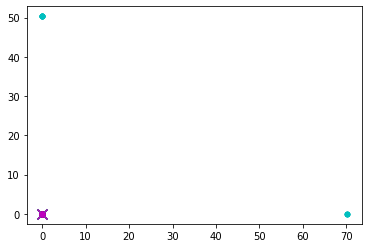

In [173]:
display_cluster(X2,km,num_clusters)


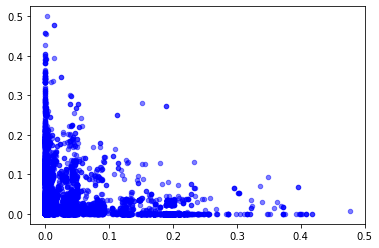

In [167]:
nmf_model3 = NMF(5)
doc_topic = nmf_model3.fit_transform(doc_word)

display_cluster(doc_topic)

In [165]:
num_clusters = 5
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(doc_topic)

KMeans(n_clusters=5, n_init=1, random_state=10)

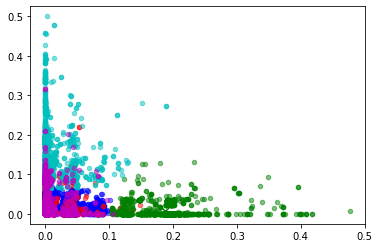

In [166]:
display_cluster(doc_topic,km,num_clusters)

In [174]:
during_final_df.to_pickle("./dummy.pkl")

NameError: name 'during_final_df' is not defined